In [27]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
from sklearn.metrics import classification_report
%matplotlib inline
plt.style.use(["dark_background"])

In [5]:
# Load the metadata.csv file.
metadata = pd.read_csv("/Users/alejandrosanchezaristizabal/Desktop/metadata.csv")
metadata.head()

,img_path,label,set
0,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
1,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
2,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
3,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
4,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train


In [6]:
# Load the metadata_one_per_label.csv file.
metadata_one_per_label = pd.read_csv("/Users/alejandrosanchezaristizabal/Desktop/metadata_one_per_label.csv")
metadata_one_per_label.head()

,Unnamed: 0,img_path,label,set
0,0,/Users/alejandrosanchezaristizabal/Desktop/ima...,1,train
1,10,/Users/alejandrosanchezaristizabal/Desktop/ima...,4,valid
2,20,/Users/alejandrosanchezaristizabal/Desktop/ima...,3,test
3,30,/Users/alejandrosanchezaristizabal/Desktop/ima...,2,test
4,40,/Users/alejandrosanchezaristizabal/Desktop/ima...,0,train


In [7]:
def preprocess_image(image):
    """Resize and normalize the image."""
    image = tf.image.resize(image, size=(64, 64))
    image = image / 255.0
    return image

def augment_image(image):
    """Augment the image to generate more data."""
    return image

def make_dataset(sources, training=False, batch_size=1, num_epochs=1, num_parallel_calls=1, 
                 shuffle_buffer_size=None):
    """
    Returns an operation to iterate over the dataset specified in sources

    Args:
        sources (list): a list of (filepath, label_id) pairs.
        training (bool): whether to apply certain processing steps defined only in training mode 
            (e.g. shuffle).
        batch_size (int): number of elements the resulting tensor should have.
        num_epochs (int): number of epochs to repeat the dataset.
        num_parallel_calls (int): number of parallel calls to use in map operations.
        shuffle_buffer_size (int): number of elements from this dataset from which the new 
            dataset will sample.

    Returns:
        A tf.data.Dataset object. It will return a tuple images of shape [N, H, W, CH] and labels 
        shape [N, 1].
    """
    def load(row):
        filepath = row["image"]
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
        return img, row["label"]

    if shuffle_buffer_size is None:
        shuffle_buffer_size = batch_size*4

    images, labels = sources["img_path"].values, sources["label"].values 
    
    ds = tf.data.Dataset.from_tensor_slices({"image": images, "label": labels}) 

    if training:
        ds = ds.shuffle(shuffle_buffer_size)
    
    ds = ds.map(load, num_parallel_calls=num_parallel_calls)
    ds = ds.map(lambda x, y: (preprocess_image(x), y))
    
    if training:
        ds = ds.map(lambda x, y: (augment_image(x), y))
        
    ds = ds.repeat(count=num_epochs)
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(1)

    return ds

In [8]:
data_set = make_dataset(metadata, training=True, batch_size=3, num_epochs=1, num_parallel_calls=1, 
                        shuffle_buffer_size=None)
data_set = iter(data_set)
data_set

In [9]:
data_set_one_per_label = make_dataset(metadata_one_per_label, training=True, batch_size=3, 
                                      num_epochs=1, num_parallel_calls=1, shuffle_buffer_size=None)
data_set_one_per_label = iter(data_set_one_per_label)
data_set_one_per_label

In [15]:
def imshow_batch_of_three(batch, show_label=True):
    """Show a sample of the images on the TFDataSet."""
    with open("/Users/alejandrosanchezaristizabal/Desktop/label_map.json") as label_map:
        label_to_map = json.load(label_map)
    image_batch = batch[0].numpy()
    label_batch = batch[1].numpy()
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i in range(3):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        if show_label:
            axarr[i].set(xlabel="label = {} - {}".format(label_batch[i], 
                                                         label_to_map[str(label_batch[i])]))

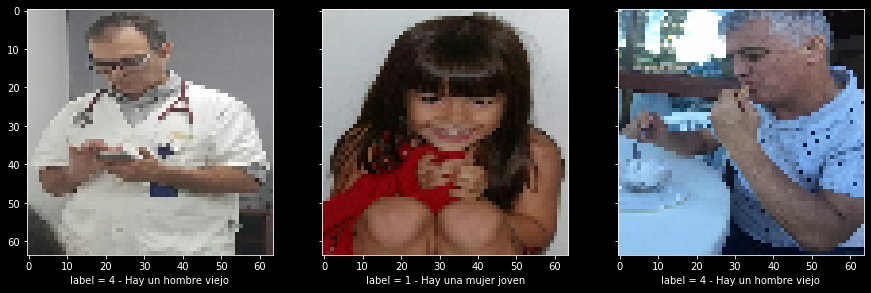

In [69]:
imshow_batch_of_three(next(data_set))

# Experimentation

## Linear model

In [93]:
# Clear session to avoid overwriting.
tf.keras.backend.clear_session()

In [94]:
def create_linear_model(input_shape, output_dim):
    """Create a linear model to classify the images."""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))
    return model

model = create_linear_model(input_shape=(64,64,3), output_dim=5)
model.summary()
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(0.0001),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 61445     
Total params: 61,445
Trainable params: 61,445
Non-trainable params: 0
_________________________________________________________________


In [95]:
BATCH_SIZE = 3
VALIDATION_STEPS = 2  # For monitoring.

In [96]:
train_sources = metadata[metadata["set"] == "train"]
valid_sources = metadata[metadata["set"] == "valid"]
test_sources = metadata[metadata["set"] == "test"]

train_dataset = make_dataset(train_sources, training=True, batch_size=BATCH_SIZE, num_epochs=1, 
                             num_parallel_calls=2)
valid_dataset = make_dataset(valid_sources, training=False, batch_size=BATCH_SIZE, num_epochs=1, 
                             num_parallel_calls=2)
test_dataset = make_dataset(test_sources, training=False, batch_size=BATCH_SIZE, num_epochs=1, 
                            num_parallel_calls=2)

# Just to check if the model is working well.
print(model.evaluate(train_dataset))
print(model.evaluate(valid_dataset))
print(model.evaluate(test_dataset))

23/23 [==============================] - 1s 22ms/step - loss: 2.0316 - accuracy: 0.0597
[2.03159819478574, 0.05970149]
4/4 [==============================] - 0s 19ms/step - loss: 2.1762 - accuracy: 0.0833
[2.176153838634491, 0.083333336]
7/7 [==============================] - 0s 20ms/step - loss: 1.9922 - accuracy: 0.1579
[1.9922470705849784, 0.15789473]


In [97]:
model.fit(x=train_dataset, epochs=30, validation_data=valid_dataset, 
          validation_steps=VALIDATION_STEPS)

Epoch 1/30
23/23 [==============================] - 2s 66ms/step - loss: 1.9765 - accuracy: 0.3433 - val_loss: 5.3335 - val_accuracy: 0.0000e+00
Epoch 2/30
23/23 [==============================] - 1s 23ms/step - loss: 1.9751 - accuracy: 0.5970 - val_loss: 2.8779 - val_accuracy: 0.0000e+00
Epoch 3/30
23/23 [==============================] - 1s 24ms/step - loss: 1.2720 - accuracy: 0.5373 - val_loss: 3.3087 - val_accuracy: 0.0000e+00
Epoch 4/30
23/23 [==============================] - 1s 23ms/step - loss: 1.2658 - accuracy: 0.5821 - val_loss: 2.7467 - val_accuracy: 0.0000e+00
Epoch 5/30
23/23 [==============================] - 1s 26ms/step - loss: 1.0543 - accuracy: 0.5672 - val_loss: 2.6213 - val_accuracy: 0.0000e+00
Epoch 6/30
23/23 [==============================] - 1s 35ms/step - loss: 0.9611 - accuracy: 0.6119 - val_loss: 2.4917 - val_accuracy: 0.0000e+00
Epoch 7/30
23/23 [==============================] - 1s 29ms/step - loss: 0.8697 - accuracy: 0.6418 - val_loss: 2.3861 - val_accura

In [98]:
print('----------REPORT ON TRAINING DATA-----------')
print(model.evaluate(train_dataset))
print('----------REPORT ON VALIDATION DATA-----------')
print(model.evaluate(valid_dataset))
print('----------REPORT ON TEST DATA-----------')
print(model.evaluate(test_dataset))

----------REPORT ON TRAINING DATA-----------
23/23 [==============================] - 0s 20ms/step - loss: 0.1399 - accuracy: 1.0000
[0.1399404280009153, 1.0]
----------REPORT ON VALIDATION DATA-----------
4/4 [==============================] - 0s 18ms/step - loss: 1.2048 - accuracy: 0.4167
[1.2048354290891439, 0.41666666]
----------REPORT ON TEST DATA-----------
7/7 [==============================] - 0s 21ms/step - loss: 0.9757 - accuracy: 0.5263
[0.9756665368165288, 0.5263158]


In [99]:
def imshow_with_predictions(model, batch, show_label=True):
    """Show a sample of the images on the TFDataSet with their corresponding predictions."""
    with open("/Users/alejandrosanchezaristizabal/Desktop/label_map.json") as label_map:
        label_to_map = json.load(label_map)
    image_batch = batch[0].numpy()
    label_batch = batch[1].numpy()
    pred_batch = model.predict(image_batch)
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i in range(3):
        img = image_batch[i, ...]
        axarr[i].imshow(img)
        pred = int(np.argmax(pred_batch[i]))
        pred_msg = "pred = {} - {},\n".format(pred, label_to_map[str(pred)])
        if show_label:
            axarr[i].set(xlabel="{}label = {} - {}".format(pred_msg, label_batch[i], 
                                                             label_to_map[str(label_batch[i])]))

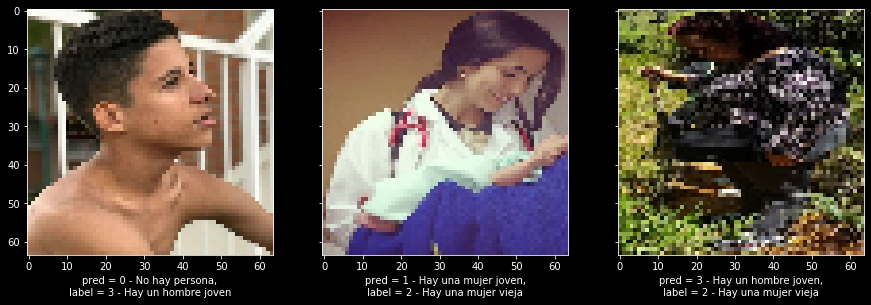

In [101]:
test_dataset = iter(test_dataset)
imshow_with_predictions(model, next(test_dataset))